This notebook best viewed here: https://nbviewer.jupyter.org

This notebook is for the coastal variety of Douglas fir GEA mapping pops

#### Purpose
• I've run the baypass commands across four servers, I need to gather the jobs and concatenate results.

#### Notebook outline

- __rsync files from servers__
    - I execute the rsync commands to transfer files from the executing servers to our lab server
- __check what needs to be done__
    - given the number of gfiles and chains, make sure all of the commands have been executed/transferred
- __gather all of the wanted resfiles and concat into single dataframes__
    - gather the files with BF, label SNP IDs, and concat into single dataframe
- __Rank loci__
    - Rank each locus for each chain by descending BF(dB) score
    - Caclulate mean BF(dB) across 5 chains, rank each locus based on mean
    - Create boolean column with True if locus is ranked in top 1% for at least 3/5 chains
    - Create boolean column with True if locus has BF(dB) >= 15 for at least 3/5 chains
    - Create boolean column with True if locus has BF(dB) >= 20 for at least 3/5 chains
- __look at BF scores for consistent top 1% ranks__
    - explore the top 1% of ranks
    - count number of SNPs >= BF(dB) thresholds {15, 20}, print if not all SNPs >= thresh are consistently in top 1% across chains

In [1]:
from pythonimports import *

In [2]:
# dir names
baydir = '/lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety_with-p6/03_maf-p05_RD-recalculated_FDC/baypass'
cmddir = op.join(baydir, 'cmd_files')
rundir = op.join(cmddir, 'run_01')
gfile_dir = op.join(baydir, 'individual_gfiles')
shdir = op.join(cmddir, 'shfiles')
resdir = op.join(cmddir, 'results')
rsyncdir = makedir(op.join(baydir, 'rsync_files'))

In [3]:
lview,dview = get_client()

56 56


# rsync files from servers

In [4]:
fs(rsyncdir)

['/lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety_with-p6/03_maf-p05_RD-recalculated_FDC/baypass/rsync_files/cedar_rsync_cmds.txt']

In [29]:
def submit_cmds(cmds):
    """Execute a list of system commands in parallel. Return cmd if there was an error."""
    global jobs
    jobs = []
    for cmd in nb(cmds):
        src,dst = cmd.split()[2:]
        jobs.append(lview.apply_async(rsync, *(src, dst)))
    watch_async(jobs)
    
    badcmds = []
    for i,j in enumerate(jobs):
        try:
            x=j.r
        except:
            badcmds.append(cmds[i])
    print('len(badcmds) = ', len(badcmds))
    
    return badcmds

In [6]:
def check_realfiles(cmds, new=False):
    """Make sure all transferred files exist.
    new is used if transferring the results from SNPs that were once REPEATS
    """
    realfiles = []
#     if new is True:
#         rundir = newrundir
#         gfile_dir = newgfiledir
#         shdir = newshdir
#         resdir = newresdir
    for d in [rundir, gfile_dir, shdir, resdir]:
        realfiles.extend(fs(d, dirs=False))
    
    expfiles = []
    for cmd in cmds:
        expfiles.append(cmd.split()[-1])
    
    print('len(realfiles) = ', len(realfiles))
    print('len(expfiles) =', len(expfiles))
    
    needed = list(set(expfiles) - set(realfiles))
    
    print('needed = ', len(needed))
    
    needed_cmds = []
    for n in needed:
        for cmd in cmds:
            if n in cmd:
                needed_cmds.append(cmd)
    print('needed_cmds = ', len(needed_cmds))
    return needed_cmds

#### cedar cmds

In [7]:
# first from cedar
cmds = read(op.join(rsyncdir, 'cedar_rsync_cmds.txt'))
len(cmds)

37891

In [8]:
cmds[-1].split()

['rsync',
 '-avz',
 'cedar:/scratch/lindb/coastal_baypass/cmd_files/shfiles/watcher.sh',
 '/lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety_with-p6/03_maf-p05_RD-recalculated_FDC/baypass/cmd_files/shfiles/watcher.sh']

In [9]:
dirs = []
for cmd in cmds:
    newfile = cmd.split()[-1]
    dname = op.dirname(newfile)
    dirs.append(dname)
for d in uni(dirs):
    assert op.exists(d)
d

'/lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety_with-p6/03_maf-p05_RD-recalculated_FDC/baypass/cmd_files/shfiles'

In [10]:
cmds[0].split()[2:]

['cedar:/scratch/lindb/coastal_baypass/cmd_files/results/coastal_all_snps_ADP-lt-1000_gfile_0000_chain_1_DIC.out',
 '/lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety_with-p6/03_maf-p05_RD-recalculated_FDC/baypass/cmd_files/results/coastal_all_snps_ADP-lt-1000_gfile_0000_chain_1_DIC.out']

In [32]:
submit_cmds(cmds[:5])

100%|██████████| 5/5 [00:00<00:00, 461.53it/s]



Watching 5 jobs ...


100%|██████████| 5/5 [00:05<00:00,  1.07s/it]

len(badcmds) =  0


[]

In [ ]:
badcmds = submit_cmds(cmds)

In [34]:
len(badcmds)

15

In [37]:
needed = check_realfiles(cmds)
len(needed)

len(realfiles) =  40897
len(expfiles) = 37891
needed =  0
needed_cmds =  0


0

In [38]:
badcmds = submit_cmds(needed)

0it [00:00, ?it/s]



Watching 0 jobs ...


0it [00:00, ?it/s]

len(badcmds) =  0


# check what needs to be done
given the number of gfiles and chains, make sure all of the commands have been executed/transferred

#### first check to make sure every sh file was exececuted (ie, check that each has a slurm .out file)

In [39]:
# the the shfiles and out files
shfiles = fs(shdir, endswith='.sh', exclude='watcher')
outs = fs(shdir, endswith='.out', exclude='watcher')
len(shfiles), len(outs)

(157, 157)

In [40]:
# which sh files were not run, print out any that weren't run
pairs = {}
for sh in shfiles:
    pairs[sh] = []
    for out in outs:
        if op.basename(sh).split(".")[0] in out:
            pairs[sh].append(out)
needed = []
for sh,outfiles in pairs.items():
    if len(outfiles) < 1:
        print(sh, len(outfiles))
        needed.append(sh)

#### go through catfiles and make sure all of the commands inside were run

In [41]:
resdir

'/lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety_with-p6/03_maf-p05_RD-recalculated_FDC/baypass/cmd_files/results'

In [42]:
# get one of the files for each of the commands that executed successfully (count the succesful cmds)
resfiles = fs(resdir, endswith='DIC.out')
len(resfiles)

7515

In [45]:
catdir = op.join(cmddir, 'run_01')
op.exists(catdir)

True

In [47]:
# get the files with the baypass commands - this matches number of sh files (good)
catfiles = fs(catdir, pattern='catfile')
len(catfiles)

157

In [48]:
# iterate through catfile commands and make sure there's a result for each
found = {}  # map prefix to output file
exe = {}  # map prefix to command used
needed_catfiles = []
catcount = Counter()
cmdcats = {}  # map cmds to catfiles
for cat in nb(catfiles):
    # get the commands
    cmds = read(cat)
    
    # assign prefixes (= num cmds) to their output
    notfound = True
    for cmd in cmds:
        assert cmd not in cmdcats
        cmdcats[cmd] = cat
        prefix = cmd.split("-outprefix")[1].split()[0]
        assert prefix not in found and 'chain' in prefix
        exe[prefix] = cmd
        found[prefix] = []
        for res in resfiles:
            if prefix in op.basename(res):
                found[prefix].append(res)
        if len(found[prefix]) > 0:
            notfound = False
            catcount[cat] += 1
    if notfound is True:
        needed_catfiles.append(cat)
            
prefix

100%|██████████| 157/157 [00:39<00:00,  3.99it/s]


'coastal_all_snps_ADP-lt-1000_gfile_1502_chain_5'

In [49]:
len(needed_catfiles)

0

In [50]:
Counter(catcount.values())

Counter({48: 156, 27: 1})

In [51]:
needed_catfiles

[]

In [52]:
# figure out which prefixes have zero output (and need to be reran) or cmds with >1 output (impossible...)
needed_cmds = []
for prefix,reslist in found.items():
    if len(reslist) == 0:
        needed_cmds.append(exe[prefix])  # get the cmd that needs to be executed
    elif len(reslist) > 1:
        print('\n', prefix, len(reslist))  # this shouldn't be possible, check anyway, print if so
len(needed_cmds)

0

In [53]:
latest_commit()

##################################################################
Current commit of pythonimports:
commit 1d94048244f2d15d6762e0ff2f8b0cb43dcfa848
Author: Brandon <lindb@vcu.edu>
Date:   Tue Dec 22 12:16:15 2020 -0700
Today:	December 23, 2020 - 18:38:55
##################################################################



# gather all of the wanted resfiles and concat into single dataframes

gather the files with BF, label SNP IDs, label environmental covariables, and concat into single dataframe

In [ ]:
# restart notebook

In [4]:
latest_commit()

##################################################################
Current commit of pythonimports:
commit 1d94048244f2d15d6762e0ff2f8b0cb43dcfa848
Author: Brandon <lindb@vcu.edu>
Date:   Tue Dec 22 12:16:15 2020 -0700
Today:	December 31, 2020 - 12:40:06
##################################################################



In [5]:
bffiles = fs(resdir, endswith='betai_reg.out')
xtxfiles = fs(resdir, endswith='pi_xtx.out')
len(bffiles), len(xtxfiles)

(7515, 7515)

In [6]:
bf = pd.read_table(bffiles[0], delim_whitespace=True)
bf.head()

,COVARIABLE,MRK,M_Pearson,SD_Pearson,BF(dB),Beta_is,SD_Beta_is,eBPis
0,1,1,0.051010,0.143831,-8.631235,0.004227,0.011712,0.143763
1,1,2,0.068187,0.140099,-9.029162,0.005564,0.011653,0.198579
2,1,3,-0.004120,0.154803,-11.697166,-0.000522,0.007232,0.025738
3,1,4,-0.083301,0.128562,-11.353031,-0.004240,0.006860,0.270385
4,1,5,0.048291,0.140174,-10.912934,0.002534,0.008152,0.121542


In [7]:
xtx = pd.read_table(xtxfiles[0], delim_whitespace=True)
xtx.head()

,MRK,M_P,SD_P,M_XtX,SD_XtX,XtXst,log10(1/pval)
0,1,0.902778,0.058954,38.660734,8.607617,26.037784,0.031791
1,2,0.895660,0.065577,39.078162,8.584471,33.358255,0.165050
2,3,0.968126,0.020901,36.570096,8.503298,15.817544,0.000247
3,4,0.962959,0.043897,37.065706,8.618123,43.829959,0.623535
4,5,0.949803,0.028133,36.876638,8.516656,30.847451,0.103296


In [8]:
def label_snps(resfile):
    """Label baypass resfiles with SNP ID using pkl files saved in 002_kickoff."""
    import os
    import pandas
    import tqdm
    # find the gfile associated with resfile
    prefix = os.path.basename(resfile).split("_chain")[0]
    chain = "chain_%s" % os.path.basename(resfile).split(prefix)[1].split("_")[2]
    
    # get the pkl file that has the ordered list of SNP IDs for the gfile
    if 'new' in resfile:
        newgfile_dir = os.path.dirname(resfile).replace("new_results", "new_individual_gfiles")
        pklfile = os.path.join(newgfile_dir, f'{prefix}_noheaderidx.pkl')
    else:
        pklfile = os.path.join(gfile_dir, f'{prefix}_noheaderidx.pkl')
    gloci = pklload(pklfile)  # read in rows with SNPIDs, but only one column
    
    # read in the resfile
    print('reading table ...')
    df = pandas.read_table(resfile, delim_whitespace=True)
    
    # map MRK column (SNP index) to locus name
    print('getting gdict ...')
    gdict = dict((num+1, locus) for num,locus in enumerate(gloci))
    
    # map covariable column to environment ID
    print('getting edict ...')
    edict = dict((num+1, env) for num,env in enumerate(efile.index))
    
    # split each covariable (env) in to its own file, label index with SNP ID
    df['env'] = df['COVARIABLE'].map(edict)
    envdfs = {chain:{}}
    for env in tqdm.tqdm(uni(df['env']), desc='annotating snps'):
        envdfs[chain][env] = df[df['env']==env].copy()
        envdfs[chain][env].index = envdfs[chain][env]['MRK'].map(gdict)
        envdfs[chain][env].index.names = ['']

    return envdfs

efile = pd.read_table(op.join(baydir, 'coastal_efile_std_HEADERIDX.txt'), index_col=0, usecols=[0,1])
dview['efile'] = efile
dview['uni'] = uni
dview['gfile_dir'] = gfile_dir
dview['pklload'] = pklload

In [41]:
# # label SNP IDs in parallel
# jobs = []
# for bffile in nb(bffiles):
#     jobs.append(lview.apply_async(label_snps, bffile))
watch_async(jobs)


Watching 7515 jobs ...


 50%|█████     | 3759/7515 [00:14<00:14, 260.86it/s]  


KeboardInterrupted


In [47]:
count=0
for j in jobs:
    if j.ready():
        count +=1 
print(count)

watch_async(jobs)

7515

Watching 7515 jobs ...


100%|██████████| 7515/7515 [00:00<00:00, 61854.39it/s]


In [48]:
# gather output by environment
envlist = {}
for j in nb(jobs):
    if j.ready():
        chain = keys(j.r)[0]
        if chain not in envlist:
            envlist[chain] = {}
        for env in j.r[chain]:
            if env not in envlist[chain]:
                envlist[chain][env] = []
            envlist[chain][env].append(j.r[chain][env])
keys(envlist)

100%|██████████| 7515/7515 [00:00<00:00, 20365.38it/s]


['chain_1', 'chain_2', 'chain_3', 'chain_4', 'chain_5']

In [49]:
# concatenate environmental output by each chain, print out num snps for each env for each chain
chaindfs = {}
for chain,envs in envlist.items():
    assert len(envs) == 19
    if chain not in chaindfs:
        chaindfs[chain] = {}
    for env,dfs in nb(envs.items(), desc=chain):
        if env not in chaindfs[chain]:
            chaindfs[chain][env] = pd.concat(dfs)
        else:
            print('crap ', chain, env)
for chain in chaindfs:
    print(ColorText(chain).bold())
    for env in chaindfs[chain]:
        print('\t',env, nrow(chaindfs[chain][env]))

chain_5: 100%|██████████| 19/19 [00:10<00:00,  1.89it/s]

chain_1
	 MAP 2254011
	 MCMT 2254011
	 FFP 2254011
	 EXT 2254011
	 AHM 2254011
	 DD5 2254011
	 EMT 2254011
	 bFFP 2254011
	 DD_0 2254011
	 MWMT 2254011
	 CMD 2254011
	 eFFP 2254011
	 TD 2254011
	 MAT 2254011
	 PAS 2254011
	 Eref 2254011
	 NFFD 2254011
	 SHM 2254011
	 MSP 2254011
chain_2
	 PAS 2254011
	 EXT 2254011
	 EMT 2254011
	 MAT 2254011
	 eFFP 2254011
	 MSP 2254011
	 Eref 2254011
	 MWMT 2254011
	 AHM 2254011
	 DD5 2254011
	 CMD 2254011
	 MAP 2254011
	 FFP 2254011
	 TD 2254011
	 SHM 2254011
	 DD_0 2254011
	 bFFP 2254011
	 MCMT 2254011
	 NFFD 2254011
chain_3
	 PAS 2254011
	 FFP 2254011
	 Eref 2254011
	 eFFP 2254011
	 MSP 2254011
	 AHM 2254011
	 EMT 2254011
	 MCMT 2254011
	 CMD 2254011
	 TD 2254011
	 DD_0 2254011
	 MAP 2254011
	 DD5 2254011
	 bFFP 2254011
	 SHM 2254011
	 NFFD 2254011
	 EXT 2254011
	 MAT 2254011
	 MWMT 2254011
chain_4
	 FFP 2254011
	 MAP 2254011
	 PAS 2254011
	 MAT 2254011
	 eFFP 2254011
	 MSP 2254011
	 NFFD 2254011
	 EXT 2254011
	 AHM 2254011
	 EMT 2254011
	 MCMT 225

In [50]:
# concatenate environmental output by each env, combine chains into single df
dflst = {}
for chain,envs in envlist.items():
    for env,dfs in nb(envs.items(), desc=chain):
        if env not in dflst:
            dflst[env] = []
        df = pd.concat(dfs)
        df.columns = [f"{chain}-{col}" for col in df.columns]
        dflst[env].append(df)
# combine chains for each env - should have done this in parallel
envdfs = {}
for env,lst in nb(dflst.items(), desc='combo'):
    assert len(lst) == 5
    df = pd.merge(lst[0], lst[1], left_index=True, right_index=True)
    df2 = pd.merge(lst[2], lst[3], left_index=True, right_index=True)
    df3 = pd.merge(df, df2, left_index=True, right_index=True)
    envdfs[env] = pd.merge(df3, lst[4], left_index=True, right_index=True)
    
    
envdfs[env].head()           

combo: 100%|██████████| 19/19 [02:37<00:00,  8.29s/it]


,chain_1-COVARIABLE,chain_1-MRK,chain_1-M_Pearson,chain_1-SD_Pearson,chain_1-BF(dB),chain_1-Beta_is,chain_1-SD_Beta_is,chain_1-eBPis,chain_1-env,chain_2-COVARIABLE,chain_2-MRK,chain_2-M_Pearson,chain_2-SD_Pearson,chain_2-BF(dB),chain_2-Beta_is,chain_2-SD_Beta_is,chain_2-eBPis,chain_2-env,chain_3-COVARIABLE,chain_3-MRK,chain_3-M_Pearson,chain_3-SD_Pearson,chain_3-BF(dB),chain_3-Beta_is,chain_3-SD_Beta_is,chain_3-eBPis,chain_3-env,chain_4-COVARIABLE,chain_4-MRK,chain_4-M_Pearson,chain_4-SD_Pearson,chain_4-BF(dB),chain_4-Beta_is,chain_4-SD_Beta_is,chain_4-eBPis,chain_4-env,chain_5-COVARIABLE,chain_5-MRK,chain_5-M_Pearson,chain_5-SD_Pearson,chain_5-BF(dB),chain_5-Beta_is,chain_5-SD_Beta_is,chain_5-eBPis,chain_5-env
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
jcf7190000000000-77738,6,1,-0.105142,0.143850,-2.704644,-0.009589,0.012788,0.343560,MSP,6,1,-0.103247,0.147413,-5.677152,-0.010303,0.013329,0.356987,MSP,6,1,-0.108743,0.145482,-4.815455,-0.010426,0.013531,0.355580,MSP,6,1,-0.104288,0.140495,-6.141851,-0.009577,0.012232,0.362858,MSP,6,1,-0.094067,0.137391,-7.398643,-0.009261,0.012065,0.353853,MSP
jcf7190000000000-77764,6,2,-0.099859,0.129947,-6.359129,-0.010124,0.011451,0.424095,MSP,6,2,-0.121466,0.134996,-6.300504,-0.012334,0.012188,0.506495,MSP,6,2,-0.122716,0.143279,-5.545702,-0.011387,0.012773,0.428692,MSP,6,2,-0.094303,0.153015,-5.911247,-0.009088,0.013616,0.297153,MSP,6,2,-0.117785,0.142586,-5.794739,-0.011592,0.012694,0.442315,MSP
jcf7190000000004-54418,6,3,-0.048377,0.157033,-7.251326,0.001092,0.007596,0.052704,MSP,6,3,-0.051437,0.151264,-10.782116,0.000860,0.007276,0.042936,MSP,6,3,-0.050947,0.149747,-11.492466,0.000918,0.007105,0.047136,MSP,6,3,-0.043383,0.153916,-11.395781,0.001050,0.007542,0.050960,MSP,6,3,-0.052768,0.149279,-11.660797,0.000716,0.007169,0.036008,MSP
jcf7190000000004-54508,6,4,0.097649,0.119296,-11.713609,0.003659,0.006082,0.261656,MSP,6,4,0.097744,0.123997,-11.892776,0.003933,0.006428,0.267076,MSP,6,4,0.098573,0.123026,-11.831760,0.003835,0.006453,0.257822,MSP,6,4,0.105508,0.118271,-11.704069,0.004382,0.006300,0.312710,MSP,6,4,0.098117,0.125987,-12.075991,0.003946,0.006166,0.282154,MSP
jcf7190000000004-54540,6,5,0.084677,0.138404,-6.805682,0.008524,0.008601,0.492596,MSP,6,5,0.095070,0.138945,-5.982927,0.009135,0.008951,0.512206,MSP,6,5,0.088263,0.136628,-7.620589,0.008808,0.008646,0.510989,MSP,6,5,0.086639,0.136883,-7.780728,0.008343,0.008484,0.487549,MSP,6,5,0.081866,0.143466,-4.035397,0.008545,0.009124,0.457173,MSP


In [52]:
# how many SNPs should be in each env file?
# read in each of the gfiles and sum rows
rows = 0
for gfile in nb(fs(gfile_dir, pattern='noheaderidx.txt')):
    df = pd.read_table(gfile, usecols=[0], header=None)
    rows += nrow(df)
rows

100%|██████████| 1503/1503 [00:08<00:00, 174.24it/s]


2254011

In [53]:
# assert each env has the expected number of rows (SNPs)
for env in envdfs:
    print(ColorText(env).bold())
    print('\t',env, nrow(envdfs[env]))
    if nrow(envdfs[env]) != rows:
        print(ColorText('CRAAAAAAAAAP').fail().bold())

MAP
	 MAP 2254011
MCMT
	 MCMT 2254011
FFP
	 FFP 2254011
EXT
	 EXT 2254011
AHM
	 AHM 2254011
DD5
	 DD5 2254011
EMT
	 EMT 2254011
bFFP
	 bFFP 2254011
DD_0
	 DD_0 2254011
MWMT
	 MWMT 2254011
CMD
	 CMD 2254011
eFFP
	 eFFP 2254011
TD
	 TD 2254011
MAT
	 MAT 2254011
PAS
	 PAS 2254011
Eref
	 Eref 2254011
NFFD
	 NFFD 2254011
SHM
	 SHM 2254011
MSP
	 MSP 2254011


In [54]:
# release some RAM
del dflst, chaindfs, df, df2, df3, dfs, envlist, jobs

# Rank all loci

In [55]:
lview,dview = get_client()

56 56


In [63]:
def rank_baypass(df):
    """Create columns to rank loci within and across chains."""
    import pandas
    import tqdm
    import math
    chains = ['chain_1', 'chain_2', 'chain_3', 'chain_4', 'chain_5']

    # rank per chain based on chain BF
    for chain in tqdm.tqdm(chains, desc='chains'):
        col = f'{chain}-BF(dB)'
#         colBF = df[col].apply(lambda x: 10**(x/10))  # convert deciban to BF
        colBF = df[col]  # no need to convert!
        ranked = dict((locus,rank+1) for (rank,locus) in enumerate(colBF.sort_values(ascending=False).index))
        df[f'rank_{chain}-BF'] = [ranked[locus] for locus in df.index]

    # mean BF
    print('getting mean BF')
    bfcols = [col for col in df if 'BF(dB)' in col and col.startswith('chain')]
    print(bfcols)
    assert len(bfcols) == 5  # 5 chains
#     mean_BF_dB = df[bfcols].mean(axis=1)
#     df['mean_BF'] = mean_BF_dB.apply(lambda x: 10**(x/10))  # convert deciban to BF
    df['mean_BF(dB)'] = df[bfcols].mean(axis=1)  # no need to convert!

    # rank of mean BF
    print('ranking mean BF')
    ranked = dict((locus,rank+1) for (rank,locus) in enumerate(df['mean_BF(dB)'].sort_values(ascending=False).index))
    df['rank_mean_BF(dB)'] = [ranked[locus] for locus in df.index]
    
    # bool column, enter True if BF >= 20 for >=3 chains, and BF >= 15 for >= 3 chains
    print('calculating bool column')
#     df['BF_gte20_for-gte3chains'] = (df[bfcols] >= 10*math.log10(20)).sum(axis=1) >= 3
#     df['BF_gte15_for-gte3chains'] = (df[bfcols] >= 10*math.log10(15)).sum(axis=1) >= 3
#     print(sum((df[bfcols] > 10*math.log10(20)).sum(axis=1) > 3))
    df['BF(dB)_gte20_for-gte3chains'] = (df[bfcols] >= 20).sum(axis=1) >= 3  # no need to convert!
    df['BF(dB)_gte15_for-gte3chains'] = (df[bfcols] >= 15).sum(axis=1) >= 3  # no need to convert!
    print(sum((df[bfcols] > 20).sum(axis=1) > 3))  # no need to convert!

    return df

In [64]:
# call rank_baypass() in parallel for each environment
t1 = dt.now()
jobs = []
for env,df in envdfs.items():
    bfcols = [col for col in df.columns if 'BF(dB)' in col and col.startswith('chain')]
    assert len(bfcols) == 5  # num chains
    jobs.append(lview.apply_async(rank_baypass, df[bfcols]))
watch_async(jobs)
formatclock(dt.now() - t1, exact=True)


Watching 19 jobs ...


100%|██████████| 19/19 [00:36<00:00,  1.90s/it]


'0-00:00:55'

In [65]:
# get the returns from the engines
new_envdfs = {}
for i,env in enumerate(envdfs):
    new_envdfs[env] = jobs[i].r
new_envdfs[env].head()

,chain_1-BF(dB),chain_2-BF(dB),chain_3-BF(dB),chain_4-BF(dB),chain_5-BF(dB),rank_chain_1-BF,rank_chain_2-BF,rank_chain_3-BF,rank_chain_4-BF,rank_chain_5-BF,mean_BF(dB),rank_mean_BF(dB),BF(dB)_gte20_for-gte3chains,BF(dB)_gte15_for-gte3chains
,,,,,,,,,,,,,,
jcf7190000000000-77738,-2.704644,-5.677152,-4.815455,-6.141851,-7.398643,133415,277048,223136,311324,432978,-5.347549,248667,False,False
jcf7190000000000-77764,-6.359129,-6.300504,-5.545702,-5.911247,-5.794739,329288,324372,267614,293345,285003,-5.982264,293155,False,False
jcf7190000000004-54418,-7.251326,-10.782116,-11.492466,-11.395781,-11.660797,416045,1264220,1501778,1471183,1551457,-10.516497,1179824,False,False
jcf7190000000004-54508,-11.713609,-11.892776,-11.831760,-11.704069,-12.075991,1567739,1618864,1602183,1564515,1668393,-11.843641,1616852,False,False
jcf7190000000004-54540,-6.805682,-5.982927,-7.620589,-7.780728,-4.035397,369922,299203,460209,480746,184377,-6.445065,330792,False,False


In [66]:
# add in the new columns
count = 0
for env,df in envdfs.items():
    update([count, env])
    # keep original columns with chain info only
    startcols = [col for col in df.columns if col.startswith('chain')]
    assert len(bfcols) == 5
    # grab the re-ranked columns
    newcols = [col for col in new_envdfs[env].columns if col not in startcols]
    envdfs[env] = pd.merge(df[startcols], new_envdfs[env][newcols], right_index=True, left_index=True)
    count += 1
envdfs[env].head()

18
MSP


,chain_1-COVARIABLE,chain_1-MRK,chain_1-M_Pearson,chain_1-SD_Pearson,chain_1-BF(dB),chain_1-Beta_is,chain_1-SD_Beta_is,chain_1-eBPis,chain_1-env,chain_2-COVARIABLE,chain_2-MRK,chain_2-M_Pearson,chain_2-SD_Pearson,chain_2-BF(dB),chain_2-Beta_is,chain_2-SD_Beta_is,chain_2-eBPis,chain_2-env,chain_3-COVARIABLE,chain_3-MRK,chain_3-M_Pearson,chain_3-SD_Pearson,chain_3-BF(dB),chain_3-Beta_is,chain_3-SD_Beta_is,chain_3-eBPis,chain_3-env,chain_4-COVARIABLE,chain_4-MRK,chain_4-M_Pearson,chain_4-SD_Pearson,chain_4-BF(dB),chain_4-Beta_is,chain_4-SD_Beta_is,chain_4-eBPis,chain_4-env,chain_5-COVARIABLE,chain_5-MRK,chain_5-M_Pearson,chain_5-SD_Pearson,chain_5-BF(dB),chain_5-Beta_is,chain_5-SD_Beta_is,chain_5-eBPis,chain_5-env,rank_chain_1-BF,rank_chain_2-BF,rank_chain_3-BF,rank_chain_4-BF,rank_chain_5-BF,mean_BF(dB),rank_mean_BF(dB),BF(dB)_gte20_for-gte3chains,BF(dB)_gte15_for-gte3chains
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
jcf7190000000000-77738,6,1,-0.105142,0.143850,-2.704644,-0.009589,0.012788,0.343560,MSP,6,1,-0.103247,0.147413,-5.677152,-0.010303,0.013329,0.356987,MSP,6,1,-0.108743,0.145482,-4.815455,-0.010426,0.013531,0.355580,MSP,6,1,-0.104288,0.140495,-6.141851,-0.009577,0.012232,0.362858,MSP,6,1,-0.094067,0.137391,-7.398643,-0.009261,0.012065,0.353853,MSP,133415,277048,223136,311324,432978,-5.347549,248667,False,False
jcf7190000000000-77764,6,2,-0.099859,0.129947,-6.359129,-0.010124,0.011451,0.424095,MSP,6,2,-0.121466,0.134996,-6.300504,-0.012334,0.012188,0.506495,MSP,6,2,-0.122716,0.143279,-5.545702,-0.011387,0.012773,0.428692,MSP,6,2,-0.094303,0.153015,-5.911247,-0.009088,0.013616,0.297153,MSP,6,2,-0.117785,0.142586,-5.794739,-0.011592,0.012694,0.442315,MSP,329288,324372,267614,293345,285003,-5.982264,293155,False,False
jcf7190000000004-54418,6,3,-0.048377,0.157033,-7.251326,0.001092,0.007596,0.052704,MSP,6,3,-0.051437,0.151264,-10.782116,0.000860,0.007276,0.042936,MSP,6,3,-0.050947,0.149747,-11.492466,0.000918,0.007105,0.047136,MSP,6,3,-0.043383,0.153916,-11.395781,0.001050,0.007542,0.050960,MSP,6,3,-0.052768,0.149279,-11.660797,0.000716,0.007169,0.036008,MSP,416045,1264220,1501778,1471183,1551457,-10.516497,1179824,False,False
jcf7190000000004-54508,6,4,0.097649,0.119296,-11.713609,0.003659,0.006082,0.261656,MSP,6,4,0.097744,0.123997,-11.892776,0.003933,0.006428,0.267076,MSP,6,4,0.098573,0.123026,-11.831760,0.003835,0.006453,0.257822,MSP,6,4,0.105508,0.118271,-11.704069,0.004382,0.006300,0.312710,MSP,6,4,0.098117,0.125987,-12.075991,0.003946,0.006166,0.282154,MSP,1567739,1618864,1602183,1564515,1668393,-11.843641,1616852,False,False
jcf7190000000004-54540,6,5,0.084677,0.138404,-6.805682,0.008524,0.008601,0.492596,MSP,6,5,0.095070,0.138945,-5.982927,0.009135,0.008951,0.512206,MSP,6,5,0.088263,0.136628,-7.620589,0.008808,0.008646,0.510989,MSP,6,5,0.086639,0.136883,-7.780728,0.008343,0.008484,0.487549,MSP,6,5,0.081866,0.143466,-4.035397,0.008545,0.009124,0.457173,MSP,369922,299203,460209,480746,184377,-6.445065,330792,False,False


In [67]:
# add column for rank consistency (True if SNP is ranked in top 1% for >= 3 chains)
# also add a column for mean_BF >= 20
for env,df in envdfs.items():
    oneperc = math.ceil(0.01*nrow(df))
    rankcols = [col for col in df if 'rank_chain' in col]
    envdfs[env]['rank_consistency_top1perc_for-gte3chains'] = (df[rankcols] < oneperc).sum(axis=1) >= 3
envdfs[env].head()

,chain_1-COVARIABLE,chain_1-MRK,chain_1-M_Pearson,chain_1-SD_Pearson,chain_1-BF(dB),chain_1-Beta_is,chain_1-SD_Beta_is,chain_1-eBPis,chain_1-env,chain_2-COVARIABLE,chain_2-MRK,chain_2-M_Pearson,chain_2-SD_Pearson,chain_2-BF(dB),chain_2-Beta_is,chain_2-SD_Beta_is,chain_2-eBPis,chain_2-env,chain_3-COVARIABLE,chain_3-MRK,chain_3-M_Pearson,chain_3-SD_Pearson,chain_3-BF(dB),chain_3-Beta_is,chain_3-SD_Beta_is,chain_3-eBPis,chain_3-env,chain_4-COVARIABLE,chain_4-MRK,chain_4-M_Pearson,chain_4-SD_Pearson,chain_4-BF(dB),chain_4-Beta_is,chain_4-SD_Beta_is,chain_4-eBPis,chain_4-env,chain_5-COVARIABLE,chain_5-MRK,chain_5-M_Pearson,chain_5-SD_Pearson,chain_5-BF(dB),chain_5-Beta_is,chain_5-SD_Beta_is,chain_5-eBPis,chain_5-env,rank_chain_1-BF,rank_chain_2-BF,rank_chain_3-BF,rank_chain_4-BF,rank_chain_5-BF,mean_BF(dB),rank_mean_BF(dB),BF(dB)_gte20_for-gte3chains,BF(dB)_gte15_for-gte3chains,rank_consistency_top1perc_for-gte3chains
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
jcf7190000000000-77738,6,1,-0.105142,0.143850,-2.704644,-0.009589,0.012788,0.343560,MSP,6,1,-0.103247,0.147413,-5.677152,-0.010303,0.013329,0.356987,MSP,6,1,-0.108743,0.145482,-4.815455,-0.010426,0.013531,0.355580,MSP,6,1,-0.104288,0.140495,-6.141851,-0.009577,0.012232,0.362858,MSP,6,1,-0.094067,0.137391,-7.398643,-0.009261,0.012065,0.353853,MSP,133415,277048,223136,311324,432978,-5.347549,248667,False,False,False
jcf7190000000000-77764,6,2,-0.099859,0.129947,-6.359129,-0.010124,0.011451,0.424095,MSP,6,2,-0.121466,0.134996,-6.300504,-0.012334,0.012188,0.506495,MSP,6,2,-0.122716,0.143279,-5.545702,-0.011387,0.012773,0.428692,MSP,6,2,-0.094303,0.153015,-5.911247,-0.009088,0.013616,0.297153,MSP,6,2,-0.117785,0.142586,-5.794739,-0.011592,0.012694,0.442315,MSP,329288,324372,267614,293345,285003,-5.982264,293155,False,False,False
jcf7190000000004-54418,6,3,-0.048377,0.157033,-7.251326,0.001092,0.007596,0.052704,MSP,6,3,-0.051437,0.151264,-10.782116,0.000860,0.007276,0.042936,MSP,6,3,-0.050947,0.149747,-11.492466,0.000918,0.007105,0.047136,MSP,6,3,-0.043383,0.153916,-11.395781,0.001050,0.007542,0.050960,MSP,6,3,-0.052768,0.149279,-11.660797,0.000716,0.007169,0.036008,MSP,416045,1264220,1501778,1471183,1551457,-10.516497,1179824,False,False,False
jcf7190000000004-54508,6,4,0.097649,0.119296,-11.713609,0.003659,0.006082,0.261656,MSP,6,4,0.097744,0.123997,-11.892776,0.003933,0.006428,0.267076,MSP,6,4,0.098573,0.123026,-11.831760,0.003835,0.006453,0.257822,MSP,6,4,0.105508,0.118271,-11.704069,0.004382,0.006300,0.312710,MSP,6,4,0.098117,0.125987,-12.075991,0.003946,0.006166,0.282154,MSP,1567739,1618864,1602183,1564515,1668393,-11.843641,1616852,False,False,False
jcf7190000000004-54540,6,5,0.084677,0.138404,-6.805682,0.008524,0.008601,0.492596,MSP,6,5,0.095070,0.138945,-5.982927,0.009135,0.008951,0.512206,MSP,6,5,0.088263,0.136628,-7.620589,0.008808,0.008646,0.510989,MSP,6,5,0.086639,0.136883,-7.780728,0.008343,0.008484,0.487549,MSP,6,5,0.081866,0.143466,-4.035397,0.008545,0.009124,0.457173,MSP,369922,299203,460209,480746,184377,-6.445065,330792,False,False,False


In [68]:
# make sure that there are no ranks repeated
for env,df in envdfs.items():
    for col in nb(df.columns, desc=env):
        if col.startswith('rank') and 'consistency' not in col:
            assert nrow(df) == luni(df[col])

MSP: 100%|██████████| 55/55 [00:03<00:00, 17.10it/s]


In [69]:
def write_file(df, file, sep='\t', index=False):
    import pandas
    df['locus'] = df.index.tolist()
    df = df[['locus'] + [col for col in df.columns if col != 'locus']]
    df.to_csv(file, sep=sep, index=index)
    return file

In [70]:
finaldir = makedir(op.join(baydir, 'final_results'))
finaldir

'/lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety_with-p6/03_maf-p05_RD-recalculated_FDC/baypass/final_results'

In [71]:
# save files - overwrite previous saved files that included newREPEATS
jobs = []
for env,df in nb(envdfs.items()):
    file = op.join(finaldir, f'coastal_maf-p05_RD-recalculated_ADP-lt-1000_{env}.txt')
    jobs.append(lview.apply_async(write_file, *(df, file)))
watch_async(jobs, phase='final')

100%|██████████| 19/19 [00:37<00:00,  1.98s/it]



Watching 19 final jobs ...


final: 100%|██████████| 19/19 [01:45<00:00,  5.53s/it]


In [72]:
# save pkl for easy loading
pkldump(envdfs, op.join(finaldir, 'envdfs_after_ranking.pkl'))

In [123]:
# print table with outliers based on several criteria
print(ColorText('Coastal\n').bold().green())
print('Env   BFConsistent20  BFConsistent15  BFMean20\t  BFMean15   BFMean13  \tRankConsistent')
for env in sorted(envdfs.keys()):
    df = envdfs[env]
    print(env,
          '\t',sum(df['BF(dB)_gte20_for-gte3chains']),
          '\t\t',sum(df['BF(dB)_gte15_for-gte3chains']),
          '\t\t',sum(df['mean_BF(dB)']>=20),
          '\t   ',sum(df['mean_BF(dB)']>=15),
          '\t',sum(df['mean_BF(dB)']>=13),
          '\t', sum(df['rank_consistency_top1perc_for-gte3chains']))

Coastal

Env   BFConsistent20  BFConsistent15  BFMean20	  BFMean15   BFMean13  	RankConsistent
AHM 	 182 		 569 		 200 	    641 	 1058 	 17043
CMD 	 1586 		 4582 		 1727 	    4980 	 7546 	 19101
DD5 	 139 		 561 		 156 	    643 	 1134 	 16972
DD_0 	 380 		 1184 		 410 	    1311 	 2125 	 18136
EMT 	 265 		 711 		 282 	    784 	 1280 	 17812
EXT 	 329 		 1235 		 371 	    1376 	 2309 	 17814
Eref 	 2627 		 7917 		 2908 	    8576 	 12977 	 19239
FFP 	 61 		 187 		 58 	    210 	 359 	 15744
MAP 	 159 		 610 		 185 	    681 	 1172 	 17731
MAT 	 143 		 556 		 147 	    608 	 1043 	 17027
MCMT 	 383 		 1069 		 417 	    1178 	 1857 	 18157
MSP 	 408 		 1403 		 433 	    1532 	 2549 	 18015
MWMT 	 338 		 1258 		 394 	    1377 	 2268 	 17796
NFFD 	 88 		 290 		 99 	    308 	 522 	 16416
PAS 	 104 		 326 		 117 	    352 	 631 	 16274
SHM 	 916 		 2225 		 983 	    2425 	 3522 	 16874
TD 	 613 		 1426 		 644 	    1515 	 2228 	 18489
bFFP 	 52 		 154 		 48 	    176 	 303 	 15520
eFFP 	 100 		 345 		 11

In [125]:
# what should I expect for the number in top 1%?
0.01*nrow(df)

22540.11

# look at BF scores for consistent top 1% ranks

In [4]:
latest_commit()

##################################################################
Current commit of pythonimports:
commit 1d94048244f2d15d6762e0ff2f8b0cb43dcfa848
Author: Brandon <lindb@vcu.edu>
Date:   Tue Dec 22 12:16:15 2020 -0700
Today:	December 31, 2020 - 13:39:34
##################################################################



In [5]:
from collections import defaultdict

In [6]:
# reload data
finaldir = op.join(baydir, 'final_results')
envdfs = pklload(op.join(finaldir, 'envdfs_after_ranking.pkl'))

MAP 17731
	number of loci with meanBF >= 0 :  17731 (True)
	number of loci with meanBF >= 10 :  2582
	number of loci with meanBF >= 15 :  681
	number of loci with meanBF >= 20 :  185
	fraction of BF >= 15 :  0.04
	fraction of BF >= 10 :  0.15


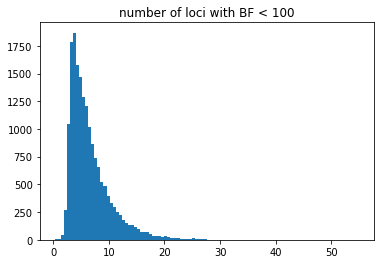



MCMT 18157
	number of loci with meanBF >= 0 :  18157 (True)
	number of loci with meanBF >= 10 :  3906
	number of loci with meanBF >= 15 :  1178
	number of loci with meanBF >= 20 :  417
	fraction of BF >= 15 :  0.06
	fraction of BF >= 10 :  0.22


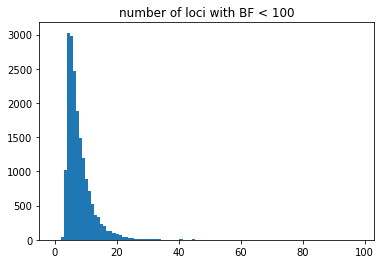



FFP 15744
	number of loci with meanBF >= 0 :  15410 (False)
	number of loci with meanBF >= 10 :  876
	number of loci with meanBF >= 15 :  210
	number of loci with meanBF >= 20 :  58
	fraction of BF >= 15 :  0.01
	fraction of BF >= 10 :  0.06


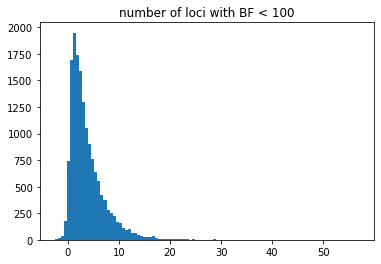



EXT 17814
	number of loci with meanBF >= 0 :  17814 (True)
	number of loci with meanBF >= 10 :  5307
	number of loci with meanBF >= 15 :  1376
	number of loci with meanBF >= 20 :  371
	fraction of BF >= 15 :  0.08
	fraction of BF >= 10 :  0.3


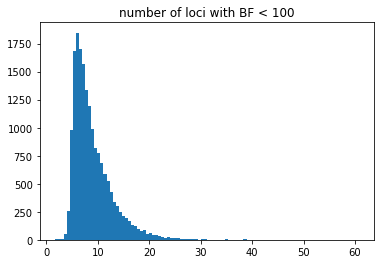



AHM 17043
	number of loci with meanBF >= 0 :  17028 (False)
	number of loci with meanBF >= 10 :  2278
	number of loci with meanBF >= 15 :  641
	number of loci with meanBF >= 20 :  200
	fraction of BF >= 15 :  0.04
	fraction of BF >= 10 :  0.13


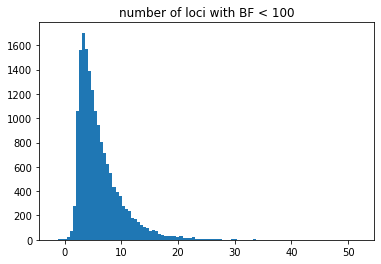



DD5 16972
	number of loci with meanBF >= 0 :  16968 (False)
	number of loci with meanBF >= 10 :  2615
	number of loci with meanBF >= 15 :  643
	number of loci with meanBF >= 20 :  156
	fraction of BF >= 15 :  0.04
	fraction of BF >= 10 :  0.15


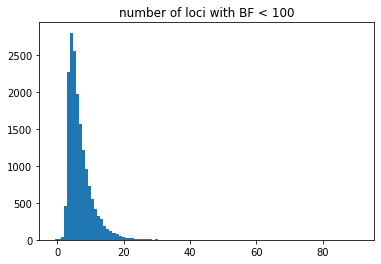



EMT 17812
	number of loci with meanBF >= 0 :  17812 (True)
	number of loci with meanBF >= 10 :  2781
	number of loci with meanBF >= 15 :  784
	number of loci with meanBF >= 20 :  282
	fraction of BF >= 15 :  0.04
	fraction of BF >= 10 :  0.16


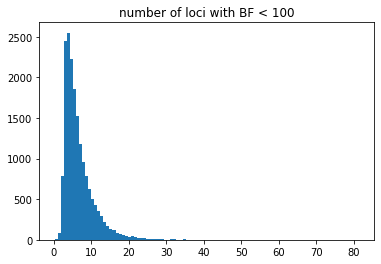



bFFP 15520
	number of loci with meanBF >= 0 :  14827 (False)
	number of loci with meanBF >= 10 :  755
	number of loci with meanBF >= 15 :  176
	number of loci with meanBF >= 20 :  48
	fraction of BF >= 15 :  0.01
	fraction of BF >= 10 :  0.05


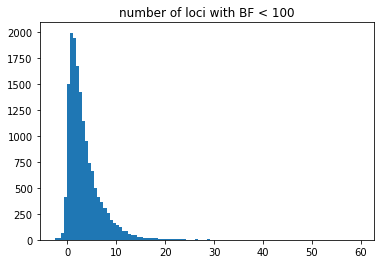



DD_0 18136
	number of loci with meanBF >= 0 :  18136 (True)
	number of loci with meanBF >= 10 :  4428
	number of loci with meanBF >= 15 :  1311
	number of loci with meanBF >= 20 :  410
	fraction of BF >= 15 :  0.07
	fraction of BF >= 10 :  0.24


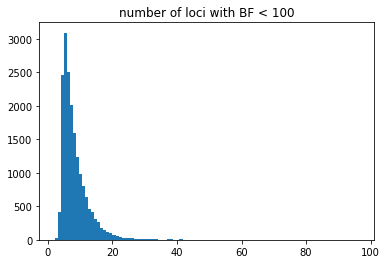



MWMT 17796
	number of loci with meanBF >= 0 :  17796 (True)
	number of loci with meanBF >= 10 :  4845
	number of loci with meanBF >= 15 :  1377
	number of loci with meanBF >= 20 :  394
	fraction of BF >= 15 :  0.08
	fraction of BF >= 10 :  0.27


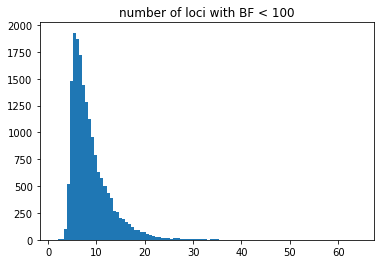



CMD 19101
	number of loci with meanBF >= 0 :  19101 (True)
	number of loci with meanBF >= 10 :  14127
	number of loci with meanBF >= 15 :  4980
	number of loci with meanBF >= 20 :  1727
	fraction of BF >= 15 :  0.26
	fraction of BF >= 10 :  0.74


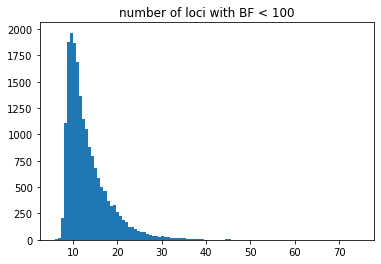



eFFP 16381
	number of loci with meanBF >= 0 :  16350 (False)
	number of loci with meanBF >= 10 :  1407
	number of loci with meanBF >= 15 :  378
	number of loci with meanBF >= 20 :  110
	fraction of BF >= 15 :  0.02
	fraction of BF >= 10 :  0.09


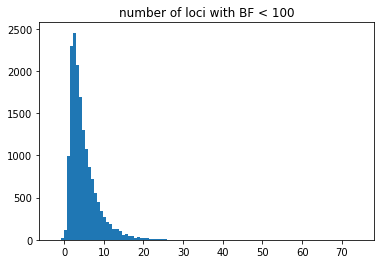



TD 18489
	number of loci with meanBF >= 0 :  18488 (False)
	number of loci with meanBF >= 10 :  4200
	number of loci with meanBF >= 15 :  1515
	number of loci with meanBF >= 20 :  644
	fraction of BF >= 15 :  0.08
	fraction of BF >= 10 :  0.23


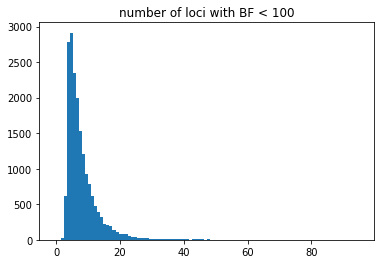



MAT 17027
	number of loci with meanBF >= 0 :  17027 (True)
	number of loci with meanBF >= 10 :  2512
	number of loci with meanBF >= 15 :  608
	number of loci with meanBF >= 20 :  147
	fraction of BF >= 15 :  0.04
	fraction of BF >= 10 :  0.15


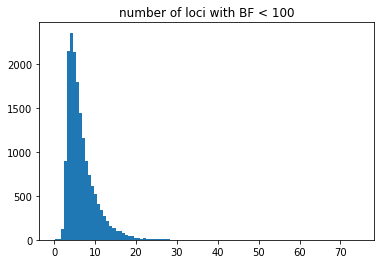



PAS 16274
	number of loci with meanBF >= 0 :  16254 (False)
	number of loci with meanBF >= 10 :  1507
	number of loci with meanBF >= 15 :  352
	number of loci with meanBF >= 20 :  117
	fraction of BF >= 15 :  0.02
	fraction of BF >= 10 :  0.09


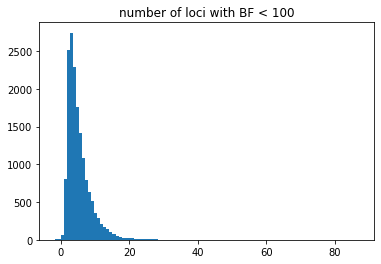



Eref 19239
	number of loci with meanBF >= 0 :  19239 (True)
	number of loci with meanBF >= 10 :  19169
	number of loci with meanBF >= 15 :  8572
	number of loci with meanBF >= 20 :  2908
	fraction of BF >= 15 :  0.45
	fraction of BF >= 10 :  1.0
	not all SNPs with BF >= 15 are consistently in top 1% : full (8576) vs 1% (8572) (diff = 4)


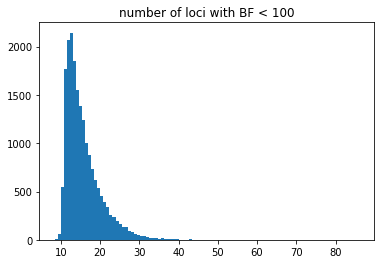



NFFD 16416
	number of loci with meanBF >= 0 :  16376 (False)
	number of loci with meanBF >= 10 :  1288
	number of loci with meanBF >= 15 :  308
	number of loci with meanBF >= 20 :  99
	fraction of BF >= 15 :  0.02
	fraction of BF >= 10 :  0.08


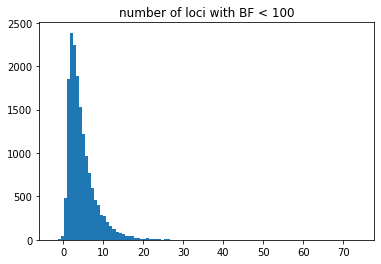



SHM 16874
	number of loci with meanBF >= 0 :  16874 (True)
	number of loci with meanBF >= 10 :  6577
	number of loci with meanBF >= 15 :  2425
	number of loci with meanBF >= 20 :  983
	fraction of BF >= 15 :  0.14
	fraction of BF >= 10 :  0.39


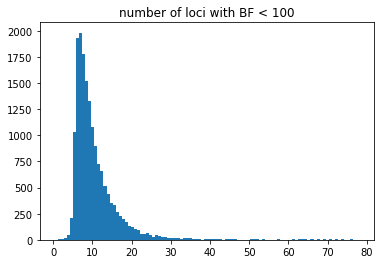



MSP 18015
	number of loci with meanBF >= 0 :  18015 (True)
	number of loci with meanBF >= 10 :  5401
	number of loci with meanBF >= 15 :  1532
	number of loci with meanBF >= 20 :  433
	fraction of BF >= 15 :  0.09
	fraction of BF >= 10 :  0.3


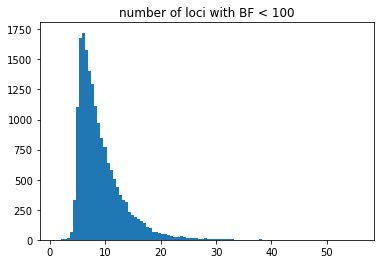




Fraction of meanBF >=15 across envs


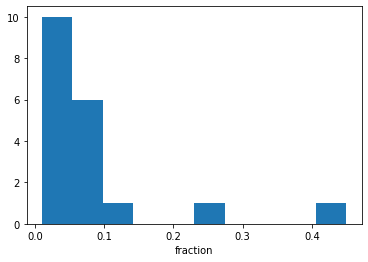

,MAP,MCMT,FFP,EXT,AHM,DD5,EMT,bFFP,DD_0,MWMT,CMD,eFFP,TD,MAT,PAS,Eref,NFFD,SHM,MSP
0,0.04,0.06,0.01,0.08,0.04,0.04,0.04,0.01,0.07,0.08,0.26,0.02,0.08,0.04,0.02,0.45,0.02,0.14,0.09


In [7]:
# for **ONLY** those loci that are consistently ranked in top 1%
# print histograms of bayes factor for each environment
# print fraction of top 1%BFs that have BF ≥ 15 or BF ≥ 20
# also look at histogram for BFs < 100

# also count number of loci across all SNPs that have BF ≥ 15 or BF ≥ 20, print if count doesn't match top 1%
fracs = defaultdict(dict)
for env,df in envdfs.items():
    df = df[df['rank_consistency_top1perc_for-gte3chains'] == True]
    BFs = df['mean_BF(dB)']
    small15 = sum(BFs >= 15)
    small20 = sum(BFs >= 20)
    print(ColorText(env).bold(), nrow(df))
    print('\tnumber of loci with meanBF >= 0 : ', sum(BFs >= 0), "(%s)" % str(sum(BFs >= 0) == nrow(df)))
    print('\tnumber of loci with meanBF >= 10 : ', sum(BFs >= 10))
    print('\tnumber of loci with meanBF >= 15 : ', small15)
    print('\tnumber of loci with meanBF >= 20 : ', small20)
    frac = round(sum(BFs >= 15)/nrow(df), 2)
    frac2 = round(sum(BFs >= 10)/nrow(df), 2)
    fracs[env][0] = frac
    print('\tfraction of BF >= 15 : ', frac)
    print('\tfraction of BF >= 10 : ', frac2)
    sum15 = sum(envdfs[env]['mean_BF(dB)'] >= 15)
    sum20 = sum(envdfs[env]['mean_BF(dB)'] >= 20)
    if small15 != sum15:
        text = '\tnot all SNPs with BF >= 15 are consistently in top 1%'
        print(ColorText(f"{text} : full ({sum15}) vs 1% ({small15}) (diff = {sum15 - small15})").warn().bold())
    if small20 != sum20:
        text = '\tnot all SNPs with BF >= 20 are consistently in top 1%'
        print(ColorText(f"{text} : full ({sum20}) vs 1% ({small20}) (diff = {sum20 - small20})").warn().bold())
    plt.hist(BFs[BFs<100], bins=100)
    plt.title('number of loci with BF < 100')
    plt.show()
    print('\n')

# create histogram for fraction of SNPs in consistent top 1% across environments
print(ColorText('\nFraction of meanBF >=15 across envs').bold())
fracdf = pd.DataFrame(fracs)
plt.hist(fracdf.loc[0,:])
plt.xlabel('fraction')
plt.show()
fracdf